## MLP class:  relu, XE

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rng = np.random.default_rng()

In [80]:
''' define  layers '''

# Fully connected layer
class FullyConnectedLayer:
    def __init__(self, input_size, output_size):
        self.weights = rng.normal(0,1,[input_size, output_size]) * np.sqrt(2.0 / input_size)
        self.bias = np.zeros([output_size,1])

    def forward(self, X):
        self.X = X
        out = np.matmul(self.weights.T, X) + self.bias
        return out

    def backward(self, d_out, learning_rate):
        dW = np.matmul(self.X, d_out.T)
        db = np.sum(d_out, axis=1, keepdims = True)
        dX = np.matmul(self.weights, d_out)
        self.weights -= learning_rate * dW
        self.bias -= learning_rate * db
        return dX

    # ReLU activation layer
class ReLU:
    def forward(self, X):
        self.mask = (X <= 0)
        out = X.copy()
        out[self.mask] = 0
        return out

    def backward(self, d_out):
        d_out[self.mask] = 0
        return d_out


# Softmax loss layer
class SoftmaxLoss:
    def forward(self, X, y):
        self.y = y
        exp_scores = np.exp(X - np.max(X, axis=0, keepdims=True))
        self.probs = exp_scores / np.sum(exp_scores, axis=0, keepdims=True)
        loss =  - np.sum(y*np.log(self.probs))
        return loss

    def backward(self):
        dX = -(self.y - self.probs)
        return dX


'''Define MLP model'''

class MLP:
    def __init__(self, nx, nh, ny):
        self.nx = nx
        self.nh = nh
        self.ny = ny
        self.fc1 = FullyConnectedLayer(self.nx,self.nh) 
        self.relu = ReLU()
        self.fc2 = FullyConnectedLayer(self.nh,self.ny) 
        self.loss = SoftmaxLoss()

    def forward(self, X):
        out = self.fc1.forward(X)
        out = self.relu.forward(out)
        out = self.fc2.forward(out)
        return out

    def backward(self, d_out, learning_rate):
        d_out = self.fc2.backward(d_out, learning_rate)
        d_out = self.relu.backward(d_out)
        d_out = self.fc1.backward(d_out, learning_rate)
        return d_out

'''Train the MLP model'''
    
def train_model(model, X_train, Y_train, learning_rate, num_epochs, batch_size):
    num_examples = X_train.shape[1]
    num_batches = num_examples // batch_size

    for epoch in range(num_epochs):
        epoch_loss = 0

        for batch in range(num_batches):
            start = batch * batch_size
            end = (batch + 1) * batch_size
            X_batch = X_train[:,start:end]
            Y_batch = Y_train[:,start:end]

            # Forward pass
            output = model.forward(X_batch)
            loss = model.loss.forward(output, Y_batch)
            epoch_loss += loss

            # Backward pass
            d_out = model.loss.backward()
            model.backward(d_out, learning_rate)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

In [81]:
'''read the data'''

# Specify the path to the CSV file
path_train = 'data/MNIST_train_1000.csv'
path_test = 'data/MNIST_test_100.csv'


data_train = np.genfromtxt(path_train, delimiter=',', skip_header=0, dtype=int)
data_test = np.genfromtxt(path_test, delimiter=',', skip_header=0, dtype=int)

m,m1 = data_train.shape[0], data_test.shape[0]

'''
get the training and test split and one-hot embedding of labels 

notice that each example is a column
'''

X_train = data_train[:,1:].T/255
Y_train = np.eye(10)[:,data_train[:,0]]
X_test = data_test[:,1:].T/255
Y_test = np.eye(10)[:, data_test[:,0] ]

nx = X_train.shape[0]
ny = Y_train.shape[0]
nh = 100

In [82]:
'''define and train the model: providing hyperparameters'''

model = MLP(nx,nh,ny)
train_model(model, X_train, Y_train, learning_rate= 0.01, num_epochs=100, batch_size=32)

Epoch 1/100, Loss: 1142.720562376623
Epoch 2/100, Loss: 487.65115523359697
Epoch 3/100, Loss: 295.079912898684
Epoch 4/100, Loss: 189.08586238032257
Epoch 5/100, Loss: 131.65822104685694
Epoch 6/100, Loss: 93.66564968801967
Epoch 7/100, Loss: 68.70598974664044
Epoch 8/100, Loss: 51.98074276881013
Epoch 9/100, Loss: 40.17667053950815
Epoch 10/100, Loss: 31.279128248343707
Epoch 11/100, Loss: 25.28198793713946
Epoch 12/100, Loss: 21.146351439064826
Epoch 13/100, Loss: 18.104951884750697
Epoch 14/100, Loss: 15.776922427267955
Epoch 15/100, Loss: 13.970302279530815
Epoch 16/100, Loss: 12.492732966700407
Epoch 17/100, Loss: 11.302266344190695
Epoch 18/100, Loss: 10.303376273434655
Epoch 19/100, Loss: 9.451552072130955
Epoch 20/100, Loss: 8.714318843660395
Epoch 21/100, Loss: 8.080488455656493
Epoch 22/100, Loss: 7.528307868148638
Epoch 23/100, Loss: 7.036710471940903
Epoch 24/100, Loss: 6.604421266458675
Epoch 25/100, Loss: 6.225762463674684
Epoch 26/100, Loss: 5.87310664910655
Epoch 27/100

# Test: 88%

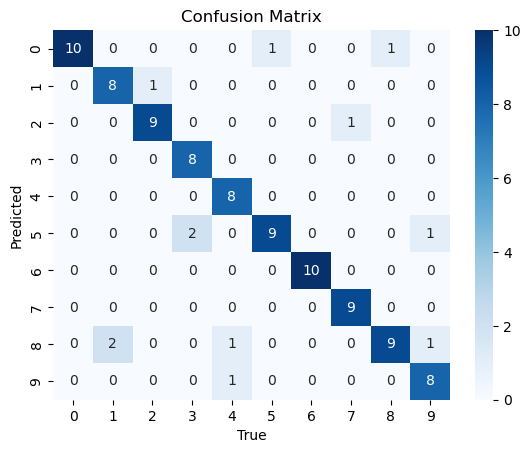

88

In [83]:
'''Forward pass the test data '''

output = model.forward(X_test)
probas = np.exp(output)/np.sum(np.exp(output), axis = 0, keepdims = True)
pos =  np.argmax(probas, axis =0)
y_pred = np.zeros_like(probas)
y_pred[pos,range(y_pred.shape[1])] = 1

''' compute the confusion matirx '''
confusion = np.zeros([10,10])
for i in range(10):
    for j in range(10):
        confusion[i,j] = np.dot(y_pred[i],Y_test[j])

''' heatmap '''       

confusion_int = confusion.astype(int)

sns.heatmap(confusion_int, annot = True, fmt='d', cmap='Blues')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

''' accuracy '''
np.trace(confusion_int)